This code creates a buffer(50 meters max) around the spill points and finds the nearest flowline intersection, asserting that the operator name is the same. It then changes the matches spills geometry location to its respective flowline intersection point. 

- you cannot export 2 geometry columns, so we only kept the flowline geometry, not the spills

## Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points
from multiprocessing import Pool, cpu_count
from sklearn.neighbors import BallTree

import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None

In [2]:
# Load Data
flowlines_gdf = gpd.read_file('split_flowlines.geojson')
spills_gdf = gpd.read_file('spills.geojson')

In [3]:
# Check if CRS is the same for both files
if flowlines_gdf.crs != spills_gdf.crs:
    flowlines_gdf = flowlines_gdf.to_crs(spills_gdf.crs)

In [4]:
print(spills_gdf.crs)
print(flowlines_gdf.crs)

EPSG:26913
EPSG:26913


In [5]:
# Check size
print(flowlines_gdf.shape)
print(spills_gdf.shape)

(26361, 31)
(849, 14)


In [6]:
# Check and count missing geometries in spills
missing_geometry_count = spills_gdf[spills_gdf.geometry.isna()].shape[0]

# Print the count of missing geometries
print(f"Number of spills with missing geometry: {missing_geometry_count}")

Number of spills with missing geometry: 180


In [7]:
# Drop rows with missing geometries
spills_gdf = spills_gdf.dropna(subset=['geometry'])
spills_gdf.reset_index(drop=True, inplace=True)

In [8]:
# Check size
print(flowlines_gdf.shape)
print(spills_gdf.shape)

(26361, 31)
(669, 14)


## Matching

In [9]:
# Split the spills_gdf into two halves
spills_gdf_1 = spills_gdf.iloc[:len(spills_gdf) // 2].copy()  # First half of the spills_gdf
spills_gdf_2 = spills_gdf.iloc[len(spills_gdf) // 2:].copy()  # Second half of the spills_gdf

In [10]:
# Initialize counters for matches and non-matches
same_operator_match_count = 0
no_match_count = 0

# Function to create a BallTree for fast nearest neighbor search
def create_balltree(flowlines_gdf):
    coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in flowlines_gdf.geometry])
    return BallTree(coords, leaf_size=15), coords

# Create BallTree for flowlines
ball_tree, flowline_coords = create_balltree(flowlines_gdf)

# Function to find the nearest flowline for each spill point that matches the operator name
def find_nearest_matching_flowline(row, flowlines_gdf, ball_tree, flowline_coords, spill_index):
    global same_operator_match_count, no_match_count
    spill_point = row.geometry
    spill_operator = row['Operator Name'].strip().lower()

    # Use BallTree to find all nearby flowlines, sorted by distance
    spill_coords = np.array([[spill_point.x, spill_point.y]])
    dist, indices = ball_tree.query(spill_coords, k=len(flowlines_gdf))
    sorted_flowlines = flowlines_gdf.iloc[indices[0]].copy()
    sorted_flowlines['distance'] = dist[0]

    # Iterate through the sorted flowlines to find the first matching operator
    for _, flowline in sorted_flowlines.iterrows():
        flowline_operator = flowline['Operator'].strip().lower()
        if spill_operator == flowline_operator:
            same_operator_match_count += 1
            print(f"Match #{same_operator_match_count}: Spill index {spill_index} matched with flowline of the same operator.")
            return flowline.name  # Return the index of the matching flowline

    # Increment the no match counter and print a message if no operator match is found
    no_match_count += 1
    print(f"No operator match found for Spill index {spill_index}")
    return None  # Return None for unmatched spills

# Function to process each spills GeoDataFrame
def process_spills_gdf(spills_gdf, flowlines_gdf, ball_tree, flowline_coords):
    # Apply the function to ensure every spill is matched with a flowline using the optimized method
    spills_gdf['nearest_flowline_index'] = spills_gdf.apply(
        lambda row: find_nearest_matching_flowline(row, flowlines_gdf, ball_tree, flowline_coords, row.name), axis=1
    )

    # Filter out unmatched spills (where nearest_flowline_index is None)
    matched_spills_gdf = spills_gdf[spills_gdf['nearest_flowline_index'].notnull()]

    # Merge the matched spills with their nearest flowlines using the indices
    matched_spills_gdf['nearest_flowline_index'] = matched_spills_gdf['nearest_flowline_index'].astype(int)
    merged_gdf = matched_spills_gdf.merge(
        flowlines_gdf, left_on='nearest_flowline_index', right_index=True, suffixes=('', '_flowline')
    )

    return merged_gdf

# Process both splits of the spills GeoDataFrame
merged_gdf_1 = process_spills_gdf(spills_gdf_1, flowlines_gdf, ball_tree, flowline_coords)

No operator match found for Spill index 0
Match #1: Spill index 1 matched with flowline of the same operator.
No operator match found for Spill index 2
Match #2: Spill index 3 matched with flowline of the same operator.
Match #3: Spill index 4 matched with flowline of the same operator.
Match #4: Spill index 5 matched with flowline of the same operator.
Match #5: Spill index 6 matched with flowline of the same operator.
Match #6: Spill index 7 matched with flowline of the same operator.
Match #7: Spill index 8 matched with flowline of the same operator.
Match #8: Spill index 9 matched with flowline of the same operator.
Match #9: Spill index 10 matched with flowline of the same operator.
Match #10: Spill index 11 matched with flowline of the same operator.
Match #11: Spill index 12 matched with flowline of the same operator.
Match #12: Spill index 13 matched with flowline of the same operator.
Match #13: Spill index 14 matched with flowline of the same operator.
Match #14: Spill index 

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
# Run the modified process function
merged_gdf_2 = process_spills_gdf(spills_gdf_2, flowlines_gdf, ball_tree, flowline_coords)

Match #288: Spill index 334 matched with flowline of the same operator.
No operator match found for Spill index 335
Match #289: Spill index 336 matched with flowline of the same operator.
No operator match found for Spill index 337
Match #290: Spill index 338 matched with flowline of the same operator.
No operator match found for Spill index 339
Match #291: Spill index 340 matched with flowline of the same operator.
No operator match found for Spill index 341
Match #292: Spill index 342 matched with flowline of the same operator.
Match #293: Spill index 343 matched with flowline of the same operator.
Match #294: Spill index 344 matched with flowline of the same operator.
Match #295: Spill index 345 matched with flowline of the same operator.
Match #296: Spill index 346 matched with flowline of the same operator.
Match #297: Spill index 347 matched with flowline of the same operator.
Match #298: Spill index 348 matched with flowline of the same operator.
Match #299: Spill index 349 matc

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
merged_gdf_1 = merged_gdf_1.drop(columns=['geometry'])  # Drop the extra geometry column
merged_gdf_2 = merged_gdf_2.drop(columns=['geometry'])  # Drop the extra geometry column

# Combine the results from both processed GeoDataFrames
merged_spills_flowlines = pd.concat([merged_gdf_1, merged_gdf_2], ignore_index=True)

# Display the combined merged GeoDataFrame
print(merged_spills_flowlines.head()) 

# Print the count of unmatched spills
print(f"Total unmatched spills: {no_match_count}")

# Save the merged dataset if needed
merged_spills_flowlines.to_file("merged_spills_flowlines.geojson", driver="GeoJSON")

    trkg_num                        Operator Name facility_type  \
0  401524345  GREAT WESTERN OPERATING COMPANY LLC  TANK BATTERY   
1  401541267                       PDC ENERGY INC      FLOWLINE   
2  401569119      KERR MCGEE OIL & GAS ONSHORE LP  TANK BATTERY   
3  401576719                     NOBLE ENERGY INC  TANK BATTERY   
4  401585074                     NOBLE ENERGY INC  TANK BATTERY   

                                          Spill_Desc Spill Type  \
0  Soil impacts were discovered during removal of...          1   
1  PDC discovered a reportable historical spill a...          1   
2  While deconstructing the Weichel 26N-11HZ tank...          1   
3  During decommisioning of facilitiy soil impact...          1   
4  During reclamation activities historical impac...          1   

                                          Root Cause  \
0                                            Unknown   
1  On January 8, 2018, historic petroleum hydroca...   
2  While deconstructing th

In [13]:
# Rename the 'geometry_flowline' column to 'geometry' in merged_spills_flowlines
merged_spills_flowlines = merged_spills_flowlines.rename(columns={'geometry_flowline': 'geometry'})

# Ensure that the GeoDataFrame recognizes the renamed column as the geometry column
merged_spills_flowlines = merged_spills_flowlines.set_geometry('geometry')

In [14]:
# Check size
print(flowlines_gdf.shape)
print(spills_gdf.shape)

(26361, 31)
(669, 14)


In [15]:
# Check size
print(flowlines_gdf.shape)
print(merged_spills_flowlines.shape)

(26361, 31)
(562, 45)


In [16]:
# Step 1: Identify the indices of flowlines present in merged_spills_flowlines
matched_flowline_indices = merged_spills_flowlines['nearest_flowline_index'].unique()

# Step 2: Filter the original flowlines_gdf to exclude those present in merged_spills_flowlines
filtered_flowlines_gdf = flowlines_gdf[~flowlines_gdf.index.isin(matched_flowline_indices)].copy()

print(list(filtered_flowlines_gdf.columns))
print(list(merged_spills_flowlines.columns))

# Create a new column 'Risk' in the no_spills DataFrame and set all its values to 0
filtered_flowlines_gdf['risk'] = 0
merged_spills_flowlines['risk'] = 1

# Step 3: Concatenate the merged_spills_flowlines with the filtered flowlines_gdf
combined_gdf = pd.concat([merged_spills_flowlines, filtered_flowlines_gdf], ignore_index=True)

# Display the first few rows of the combined GeoDataFrame
print(combined_gdf.head())

['ACTIONDESCRIPTION', 'BEDDINGMATERIAL', 'COMPANY_NAME', 'CONSTRUCTDATE', 'Diam_in', 'ENDLAT', 'ENDLONG', 'ENTIRELINEREMOVED', 'FLOWLINEACTION', 'FLOWLINEID', 'Fluid', 'LOCATIONTYPE', 'LOCATION_ID', 'Length_ft', 'MAXOPPRESSURE', 'Material', 'OPERATOR_NUM', 'Operator', 'PIPEMATERIAL', 'RECEIVE_DATE', 'SHAPE_Length', 'STARTLAT', 'STARTLOCATIONID', 'STARTLONG', 'Status', 'TYPEOFFLUIDTRANS', 'average_pop_density', 'Max_Elevation', 'Min_Elevation', 'Avg_Elevation', 'geometry']
['trkg_num', 'Operator Name', 'facility_type', 'Spill_Desc', 'Spill Type', 'Root Cause', 'Preventative Measure', 'Root Cause Type', 'Detailed Root Cause Type', 'Long', 'Lat', 'facility_status', 'Metallic?', 'nearest_flowline_index', 'ACTIONDESCRIPTION', 'BEDDINGMATERIAL', 'COMPANY_NAME', 'CONSTRUCTDATE', 'Diam_in', 'ENDLAT', 'ENDLONG', 'ENTIRELINEREMOVED', 'FLOWLINEACTION', 'FLOWLINEID', 'Fluid', 'LOCATIONTYPE', 'LOCATION_ID', 'Length_ft', 'MAXOPPRESSURE', 'Material', 'OPERATOR_NUM', 'Operator', 'PIPEMATERIAL', 'RECEI

In [17]:
print(combined_gdf.shape)

(26629, 46)


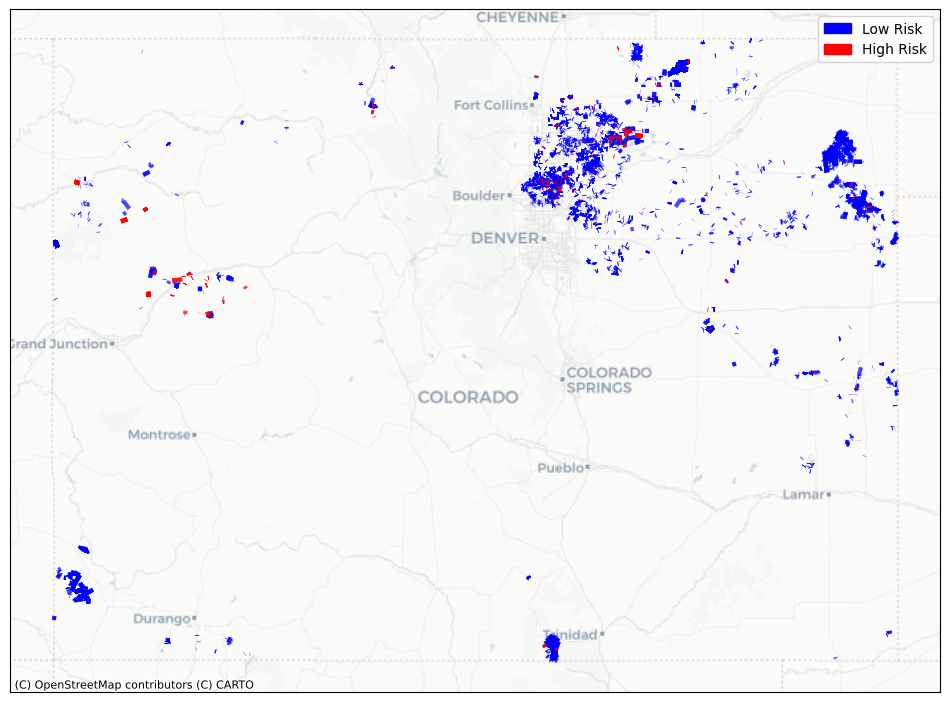

In [18]:
# Convert CRS to EPSG:3857 for contextily base map
combined_gdf_wm = combined_gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
combined_gdf_wm = combined_gdf_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
combined_gdf_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

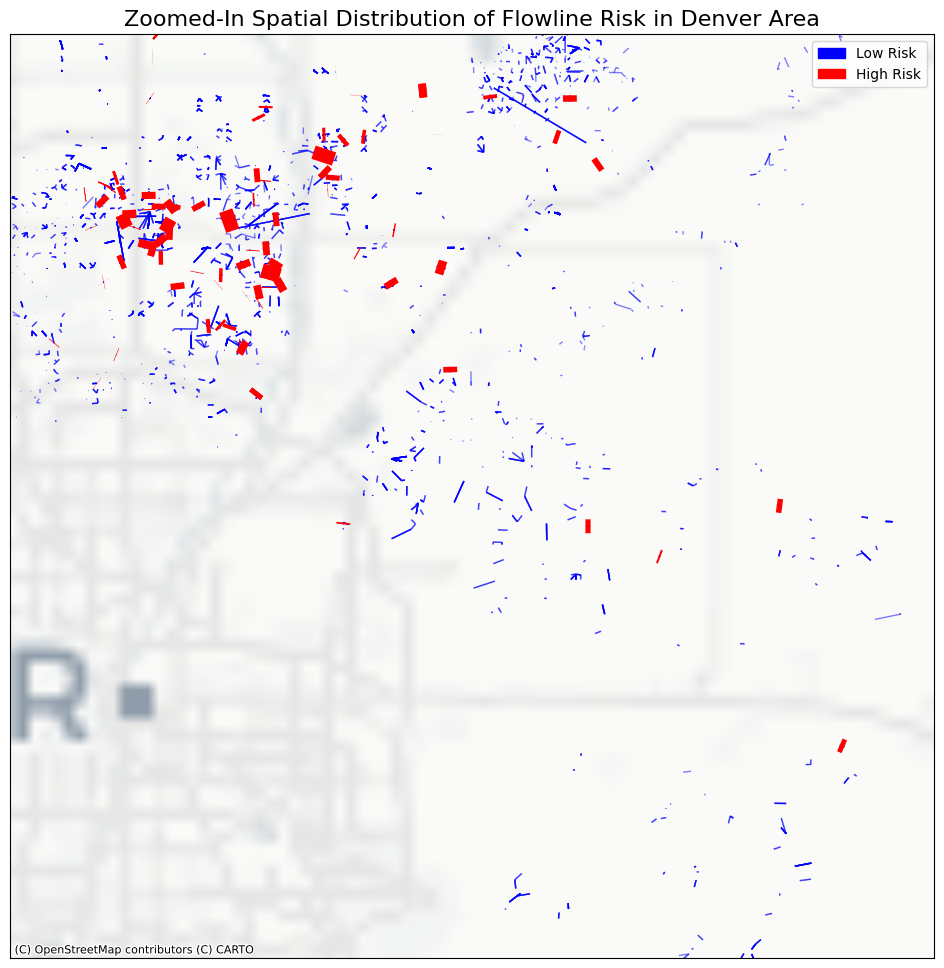

In [19]:
# Separate the data by risk level
low_risk = combined_gdf_wm[combined_gdf_wm['risk'] == 0]
high_risk = combined_gdf_wm[combined_gdf_wm['risk'] == 1]

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size

# Plot low-risk geometries (blue) first
low_risk.plot(ax=ax, color='blue', alpha=0.5, linewidth=1)

# Plot high-risk geometries (red) on top with a much larger size
high_risk.plot(ax=ax, color='red', alpha=1.0, linewidth=10)  # Significantly increased line width

# Add a lighter, minimalistic base map to reduce visual clutter
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# Set the plot limits to zoom into the desired area
ax.set_xlim([-11700000, -11600000])
ax.set_ylim([4800000, 4900000])

# Clean up axis
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

# Optional: Add title
ax.set_title('Zoomed-In Spatial Distribution of Flowline Risk in Denver Area', fontsize=16)

# Display the plot
plt.show()

In [20]:
combined_gdf.to_file("combined_gdf.geojson", driver="GeoJSON")
flowlines_gdf.to_file("flowlines_gdf.geojson", driver="GeoJSON")
merged_spills_flowlines.to_file("spills_gdf.geojson", driver="GeoJSON")